<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/GAN_1_Really_Simple_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simplificación de 

https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87


In [19]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY



In [20]:
# Datos
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)


In [21]:
width=28
height=28
channels=1

in_shape = X_train.shape
in_shape = in_shape[1:]
OPTIMZADOR_ADAM = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

In [22]:
# Generador

model_gen = Sequential()
model_gen.add(Dense(256, input_shape=(100,)))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(512))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(1024))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(np.prod(in_shape), activation='tanh'))
model_gen.add(Reshape(in_shape))
model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1024)             

In [23]:
# Discriminador

model_Disc = Sequential()
model_Disc.add(Flatten(input_shape=in_shape))
model_Disc.add(Dense(128, input_shape=in_shape))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(64))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(1, activation='sigmoid'))
model_Disc.summary()
model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
________________________________________________

In [24]:
# modelo combinado

model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

model_gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         1493520   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 108801    
Total params: 1,602,321
Trainable params: 1,598,737
Non-trainable params: 3,584
_________________________________________________________________


In [25]:

epochs = 1000
batch = 10

# Entrenamiento

DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

for cnt in range(epochs):

    ## train discriminator
    random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
    legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape((np.int64(batch/2),)+in_shape)

    gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
    syntetic_images = model_gen.predict(gen_noise)

    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)


    # train generator

    noise = np.random.normal(0, 1, (batch, 100))
    y_mislabled = np.ones((batch, 1))

    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss
    
    
    

epoch: 0, [Discriminator :: d_loss: 0.917025], [ Generator :: loss: 0.781186]
epoch: 1, [Discriminator :: d_loss: 0.770883], [ Generator :: loss: 0.754521]
epoch: 2, [Discriminator :: d_loss: 0.597387], [ Generator :: loss: 0.723135]
epoch: 3, [Discriminator :: d_loss: 0.473268], [ Generator :: loss: 0.613078]
epoch: 4, [Discriminator :: d_loss: 0.488224], [ Generator :: loss: 0.552658]
epoch: 5, [Discriminator :: d_loss: 0.532855], [ Generator :: loss: 0.632458]
epoch: 6, [Discriminator :: d_loss: 0.358738], [ Generator :: loss: 0.529007]
epoch: 7, [Discriminator :: d_loss: 0.579690], [ Generator :: loss: 0.507870]
epoch: 8, [Discriminator :: d_loss: 0.555105], [ Generator :: loss: 0.508079]
epoch: 9, [Discriminator :: d_loss: 0.637796], [ Generator :: loss: 0.488203]
epoch: 10, [Discriminator :: d_loss: 0.425538], [ Generator :: loss: 0.444384]
epoch: 11, [Discriminator :: d_loss: 0.619864], [ Generator :: loss: 0.446272]
epoch: 12, [Discriminator :: d_loss: 0.699810], [ Generator ::

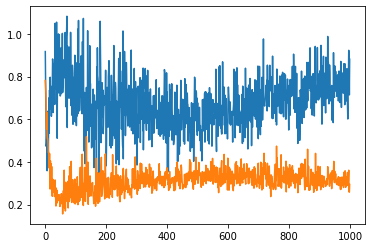

In [26]:
% matplotlib inline 
plt.figure
plt.plot(DD_loss)
plt.plot(GG_loss)

# Generar datos

In [27]:
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
syntetic_images = model_gen.predict(gen_noise)

In [28]:
syntetic_images.shape

(10, 28, 28, 1)

(-0.5, 27.5, 27.5, -0.5)

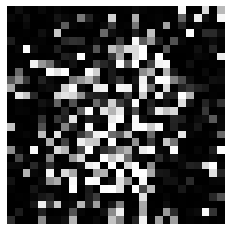

In [29]:
plt.imshow(syntetic_images[0,:,:,0],cmap='gray')
plt.axis('off')